In [1]:
import math, random
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [2]:
IMG_SIZE = 32
EMBED_DIM = 64
ATTENTION_HEADS = 4
BATCH_SIZE = 12
EPOCHS = 10
LR = 3e-4
TEMPERATURE = 0.07
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### synth dataset

In [3]:
colors = ['red','green','blue','yellow','purple','orange', 'pink', 'brown', 'gray']
shapes = ['square','circle','triangle']
positions = ['left','center','right', 'top', 'bottom', 'top-left', 'top-right', 'bottom-left', 'bottom-right']

### draw image shapes

In [4]:
def draw_sample(color, shape, position, img_size = IMG_SIZE):
  img = Image.new('RGB', (img_size, img_size), 'white')
  draw = ImageDraw.Draw(img)

  margin = 6
  h = w = img_size - 2*margin

  # Calculate x coordinates
  if 'left' in position:
      x0 = margin
      x1 = margin + w // 2
  elif 'top-left' in position:
      x0 = margin
      x1 = margin + w // 2
  elif 'bottom-left' in position:
      x0 = margin
      x1 = margin + w // 2
  elif 'right' in position:
      x0 = margin + w // 2
      x1 = img_size - margin
  elif 'top-right' in position:
      x0 = margin + w // 2
      x1 = img_size - margin
  elif 'bottom-right' in position:
      x0 = margin + w // 2
      x1 = img_size - margin
  else: # center or vertical positions
      x0 = margin + w // 4
      x1 = margin + 3 * w // 4

  # Calculate y coordinates
  if 'top' in position:
      y0 = margin
      y1 = margin + h // 2
  elif 'top-left' in position:
      y0 = margin
      y1 = margin + h // 2
  elif 'top-right' in position:
      y0 = margin
      y1 = margin + h // 2
  elif 'bottom' in position:
      y0 = margin + h // 2
      y1 = img_size - margin
  elif 'bottom-left' in position:
      y0 = margin + h // 2
      y1 = img_size - margin
  elif 'bottom-right' in position:
      y0 = margin + h // 2
      y1 = img_size - margin
  else: # center or horizontal positions
      y0 = margin + h // 4
      y1 = margin + 3 * h // 4

  if shape=='square':
      draw.rectangle([x0,y0,x1,y1], fill=color, outline='black')
  elif shape=='circle':
      draw.ellipse([x0,y0,x1,y1], fill=color, outline='black')
  else:  # triangle
      draw.polygon([((x1+x0)//2, y0), (x0, y1), (x1, y1)], fill=color, outline='black')
  return img

### class for building dataset

In [5]:
class ShapesDataset():
    def __init__(self):
        self.images = []
        self.captions = []

        for c in colors:
            for s in shapes:
                for p in positions:
                    img = draw_sample(c, s, p)
                    cap = f"{c} {s} {p}"
                    self.images.append(torch.from_numpy(np.asarray(img)).permute(2,0,1).float()/255.0)
                    self.captions.append(cap)

        self.vocab, self.word2idx = self.build_vocab(self.captions)

    def build_vocab(self, texts):
        words = sorted({w for t in texts for w in t.split()})
        vocab = ['[CLS]'] + words
        w2i = {w:i for i, w in enumerate(vocab)}
        return vocab, w2i
    
    def encode_text(self, text):
        toks = [self.word2idx['[CLS]']] + [self.word2idx[w] for w in text.split()]
        return torch.tensor(toks, dtype=torch.long)
    
    def __getitem__(self, idx):
        return self.images[idx], self.encode_text(self.captions[idx]), self.captions[idx]
    
    def __len__(self):
        return len(self.images)
    

In [6]:
full_ds = ShapesDataset()
VOCAB_SIZE = len(full_ds.vocab)

/tmp/ipykernel_3125918/2620970586.py:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  self.images.append(torch.from_numpy(np.asarray(img)).permute(2,0,1).float()/255.0)


In [7]:
print(VOCAB_SIZE)
print(full_ds.vocab)

22
['[CLS]', 'blue', 'bottom', 'bottom-left', 'bottom-right', 'brown', 'center', 'circle', 'gray', 'green', 'left', 'orange', 'pink', 'purple', 'red', 'right', 'square', 'top', 'top-left', 'top-right', 'triangle', 'yellow']


# train-val data creation

In [8]:
len(full_ds)

243

In [9]:
train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size

print(f"{train_size} : {val_size}")

194 : 49


In [10]:
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])

In [11]:
len(train_ds)

194

In [12]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

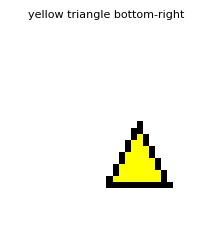

In [13]:
# @title
imgs, _, caps = next(iter(train_loader))
idx = random.randint(0, len(imgs) - 1)
img = (imgs[idx].permute(1, 2, 0).numpy() * 255).astype(np.uint8) # Convert to displayable image

plt.figure(figsize=(2.5, 2.5))
plt.imshow(img)
plt.title(caps[idx], fontsize=8)
plt.axis('off')
plt.show()

In [14]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim = EMBED_DIM):
        super().__init__()
        self.convolutions = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.ReLU()   # do we need this ?
        )

        self.projection = nn.Linear(256, embed_dim)
        self.layernorm1 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.convolutions(x)
        x = x.mean(dim=[2,3])
        x = self.projection(x)
        x = F.normalize(self.layernorm1(x), dim=-1)
        return x

In [15]:
class TextEncoder(nn.Module):
    def __init__(self, 
                 embed_dim=EMBED_DIM, 
                 num_heads=ATTENTION_HEADS,
                 vocab_size = VOCAB_SIZE,
                 context_window = 4):
        super().__init__()
        self.tok = nn.Embedding(vocab_size, embed_dim)
        self.pos = nn.Embedding(context_window, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, toks):
        N, L = toks.shape # (b, 4)
        pos_ids = torch.arange(L, device=toks.device).unsqueeze(0).expand(N, L)
        x = self.tok(toks) + self.pos(pos_ids)
        x = self.attn(x,x,x)[0]
        x = x[:, 0]
        x = self.proj(x)
        x = F.normalize(self.norm(x), dim=-1)
        return x


### clip loss

In [16]:
def clip_loss(img_emb, txt_emb, temperature = TEMPERATURE):
    logits = (img_emb @ txt_emb.T) / temperature
    targets = torch.arange(img_emb.size(0), device=img_emb.device)
    loss_i = F.cross_entropy(logits, targets)
    loss_t = F.cross_entropy(logits.T, targets)
    return ((loss_i + loss_t) / 2.0)

### model, data, optimizer

In [17]:
img_enc = ImageEncoder().to(device)
txt_enc = TextEncoder().to(device)

params = list(img_enc.parameters()) + list(txt_enc.parameters())
opt = torch.optim.AdamW(params, lr=LR)

Sample image and caption for embeddings visualization: 'blue square bottom'


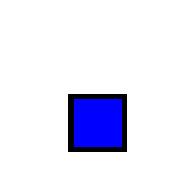

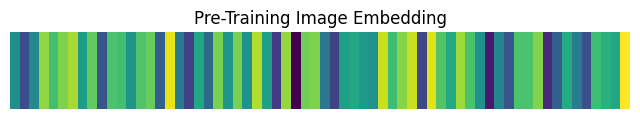

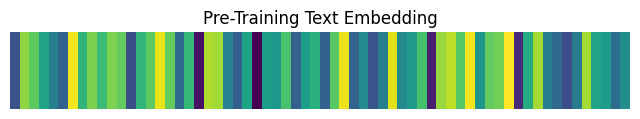

In [18]:
def show_image(t, title=None):
    img = (t.permute(1,2,0).numpy()*255).astype(np.uint8)
    plt.figure(figsize=(2.2,2.2))
    plt.axis('off')
    if title: plt.title(title, fontsize=8)
    plt.imshow(img); plt.show()

# @title
img_enc.eval(); txt_enc.eval()

with torch.no_grad():
    # Select a random index
    random_idx = random.randrange(len(full_ds))
    sample_img, sample_toks, sample_cap = full_ds[random_idx]
    sample_img = sample_img.unsqueeze(0).to(device)
    sample_toks = sample_toks.unsqueeze(0).to(device)
    pre_train_img_emb = img_enc(sample_img).squeeze(0).cpu().numpy()
    pre_train_txt_emb = txt_enc(sample_toks).squeeze(0).cpu().numpy()

# Display the sample image and caption
print(f"Sample image and caption for embeddings visualization: '{sample_cap}'")
show_image(sample_img.squeeze(0).cpu())

# Function to visualize embeddings (simplified)
def plot_embedding(embedding, title):
    plt.figure(figsize=(8, 1))
    plt.imshow(embedding.reshape(1, -1), aspect='auto', cmap='viridis')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_embedding(pre_train_img_emb, "Pre-Training Image Embedding")
plot_embedding(pre_train_txt_emb, "Pre-Training Text Embedding")

In [19]:
best_val = float('inf')

for epoch in range(1, EPOCHS+1):
    img_enc.train(); txt_enc.train()
    total = 0.0

    for imgs, toks, _ in train_loader:
        imgs = imgs.to(device); toks = toks.to(device)
        opt.zero_grad(set_to_none=True)
        ie = img_enc(imgs); te = txt_enc(toks)
        loss = clip_loss(ie, te)
        loss.backward()
        opt.step()
        total += loss.item()*imgs.size(0)
    train_loss = total / (len(train_loader)*BATCH_SIZE)

    # quick val
    img_enc.eval(); txt_enc.eval()
    with torch.no_grad():
        vtotal, n = 0.0, 0
        for imgs, toks, _ in val_loader:
            imgs = imgs.to(device); toks = toks.to(device)
            vtotal += clip_loss(img_enc(imgs), txt_enc(toks)).item()*imgs.size(0)
            n += imgs.size(0)
        val_loss = vtotal / n

    print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")
    best_val = min(best_val, val_loss)

Epoch 01 | train 2.3800 | val 2.4248
Epoch 02 | train 2.3099 | val 2.3667
Epoch 03 | train 2.0394 | val 2.3078
Epoch 04 | train 1.6316 | val 1.4638
Epoch 05 | train 0.7979 | val 1.0671
Epoch 06 | train 0.5801 | val 0.3352
Epoch 07 | train 0.3314 | val 0.2597
Epoch 08 | train 0.2494 | val 0.3324
Epoch 09 | train 0.2511 | val 0.4543
Epoch 10 | train 0.3344 | val 0.1744


Sample image and caption for embeddings visualization: 'blue square bottom'


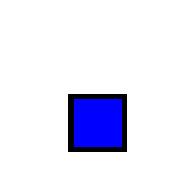

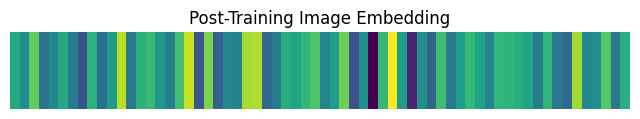

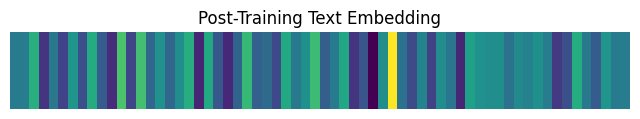

In [20]:
img_enc.eval(); txt_enc.eval()
with torch.no_grad():
    # Use the same random index as before training
    sample_img, sample_toks, sample_cap = full_ds[random_idx]
    sample_img = sample_img.unsqueeze(0).to(device)
    sample_toks = sample_toks.unsqueeze(0).to(device)

    post_train_img_emb = img_enc(sample_img).squeeze(0).cpu().numpy()
    post_train_txt_emb = txt_enc(sample_toks).squeeze(0).cpu().numpy()

# Display the sample image and caption
print(f"Sample image and caption for embeddings visualization: '{sample_cap}'")
show_image(sample_img.squeeze(0).cpu())

plot_embedding(post_train_img_emb, "Post-Training Image Embedding")
plot_embedding(post_train_txt_emb, "Post-Training Text Embedding")

In [21]:
# @title
#Calculate and print dot products
print("\nDot product between image and text embeddings:")
print(f"  Before training: {np.dot(pre_train_img_emb, pre_train_txt_emb):.4f}")
print(f"  After training: {np.dot(post_train_img_emb, post_train_txt_emb):.4f}")


Dot product between image and text embeddings:
  Before training: -0.0836
  After training: 0.7558
